In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# loading the dataset 
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/255dataset/train.csv",encoding='ISO-8859-1')
df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
#dropping 3 columns.
df = df.drop(['id','keyword','location'],axis=1)
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df['target'].value_counts()


0    4342
1    3271
Name: target, dtype: int64

In [ ]:
#Balancing the dataset
df_0_class = df[df['target']==0]
df_1_class = df[df['target']==1]
df_0_class_undersampled = df_0_class.sample(df_1_class.shape[0])
df = pd.concat([df_0_class_undersampled, df_1_class], axis=0)


In [ ]:
#Splitting the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'],df['target'], stratify=df['target'])

In [ ]:
#Installing tensorflow_text
 pip install tensorflow-text

     |████████████████████████████████| 4.9 MB 26.7 MB/s 
     |████████████████████████████████| 462 kB 68.0 MB/s 


In [ ]:
#Bert preprocessor and Encoder.
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")


In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text-layer')
preprocessed_text = preprocess(text_input)
outputs = encoder(preprocessed_text)
d_layer = tf.keras.layers.Dropout(0.1, name="dropout-layer")(outputs['pooled_output'])
d_layer = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(d_layer)
model = tf.keras.Model(inputs=[text_input], outputs = [d_layer])

In [ ]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text-layer (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text-layer[0][0]']             
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
m= [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=m)

In [ ]:
#Evaluation of Model
model.fit(X_train, y_train, epochs=10)


Epoch 1/10
154/154 [==============================] - 2162s 14s/step - loss: 0.6467 - accuracy: 0.6266 - precision: 0.6227 - recall: 0.6425
Epoch 2/10
103/154 [===================>..........] - ETA: 11:47 - loss: 0.6083 - accuracy: 0.6778 - precision: 0.6695 - recall: 0.6827

In [ ]:
model.evaluate(X_test, y_test)


52/52 [==============================] - 20s 330ms/step - loss: 0.5306 - accuracy: 0.7561 - precision: 0.7539 - recall: 0.7604


[0.5306404829025269,
 0.7561124563217163,
 0.7539393901824951,
 0.7603911757469177]

In [ ]:
#Here is the classification report.
import numpy as np
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.5, 1, 0)
from sklearn.metrics import confusion_matrix, classification_report
matrix = confusion_matrix(y_test, y_predicted)
matrix

array([[615, 203],
       [196, 622]])

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.76      0.75      0.76       818
           1       0.75      0.76      0.76       818

    accuracy                           0.76      1636
   macro avg       0.76      0.76      0.76      1636
weighted avg       0.76      0.76      0.76      1636



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [ ]:
#Precision and Accuracy for the Bert 
print('accuracy_score: %.3f' % accuracy_score(y_test, y_predicted))
print('Recall: %.3f' % recall_score(y_test, y_predicted))
print('Precision: %.3f' % precision_score(y_test, y_predicted))
print('F1 Score: %.3f' % f1_score(y_test, y_predicted))

accuracy_score: 0.756
Recall: 0.760
Precision: 0.754
F1 Score: 0.757


In [44]:
import sklearn.metrics as metrics

def ROC_Curve(y_train, y_train_predict):
    x,y = np.arange(0,1.1,0.1),np.arange(0,1.1,0.1)
    plt.plot(x, y, '--')

    #### Plot for train
    fpr_train, tpr_train, thresholds = metrics.roc_curve(y_train, y_train_predict)
    roc_auc_train = metrics.auc(fpr_train, tpr_train)
    plt.plot(fpr_train, tpr_train, marker='o', label = 'Train AUC = %0.3f' % roc_auc_train)

    
    plt.legend(loc = 'lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return(roc_auc_train)

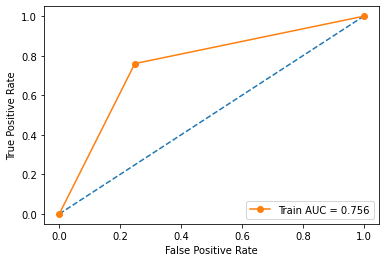

In [45]:
roc_auc_train_LR = ROC_Curve(y_test,y_predicted)